In [1]:
from IPython.display import display
from IPython.display import Image
from utils import * # Code shared across more than one notebook

# A Python tutorial on validating gVirtualXRay:
## Analytic simulation vs. Monte Carlo simulation
### With a realistic beam spectrum and taking into account the energy response of the detector
#### Authors: T. Wen, A. Sujar and F. P. Vidal

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to real images from the [Visible Human Project (VHP)](https://www.nlm.nih.gov/research/visible/visible_human.html). We take into account i) a realistic beam spectrum and ii) the energy response of the detector.

**Material and Methods:** <!--We simulate an image with gVirtualXRay and compare it with a ground truth image. For this purpose, we use [Gate],(http://www.opengatecollaboration.org/) a wrapper for CERN's state-of-the-art Monte Caro simulation tool: [Geant4](https://geant4.web.cern.ch/).-->

<!-- In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is polychromatic and the energy response of the detector is considered.
 -->
<!-- ![Geometric parameters](doc/setup.png)
 -->
<!--The sample is made of a 70x70x15mm box of water, in which 5 columns of 3 spheres of different radii (2, 3.5, and 5mm) have been inserted. A given material is associated to the spheres of each column (bone (cortical), blood (whole), brain (grey/white matter), breast tissue, and adipose tissue). The columns are ordered in decreasing density.--> We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). <!--The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).-->

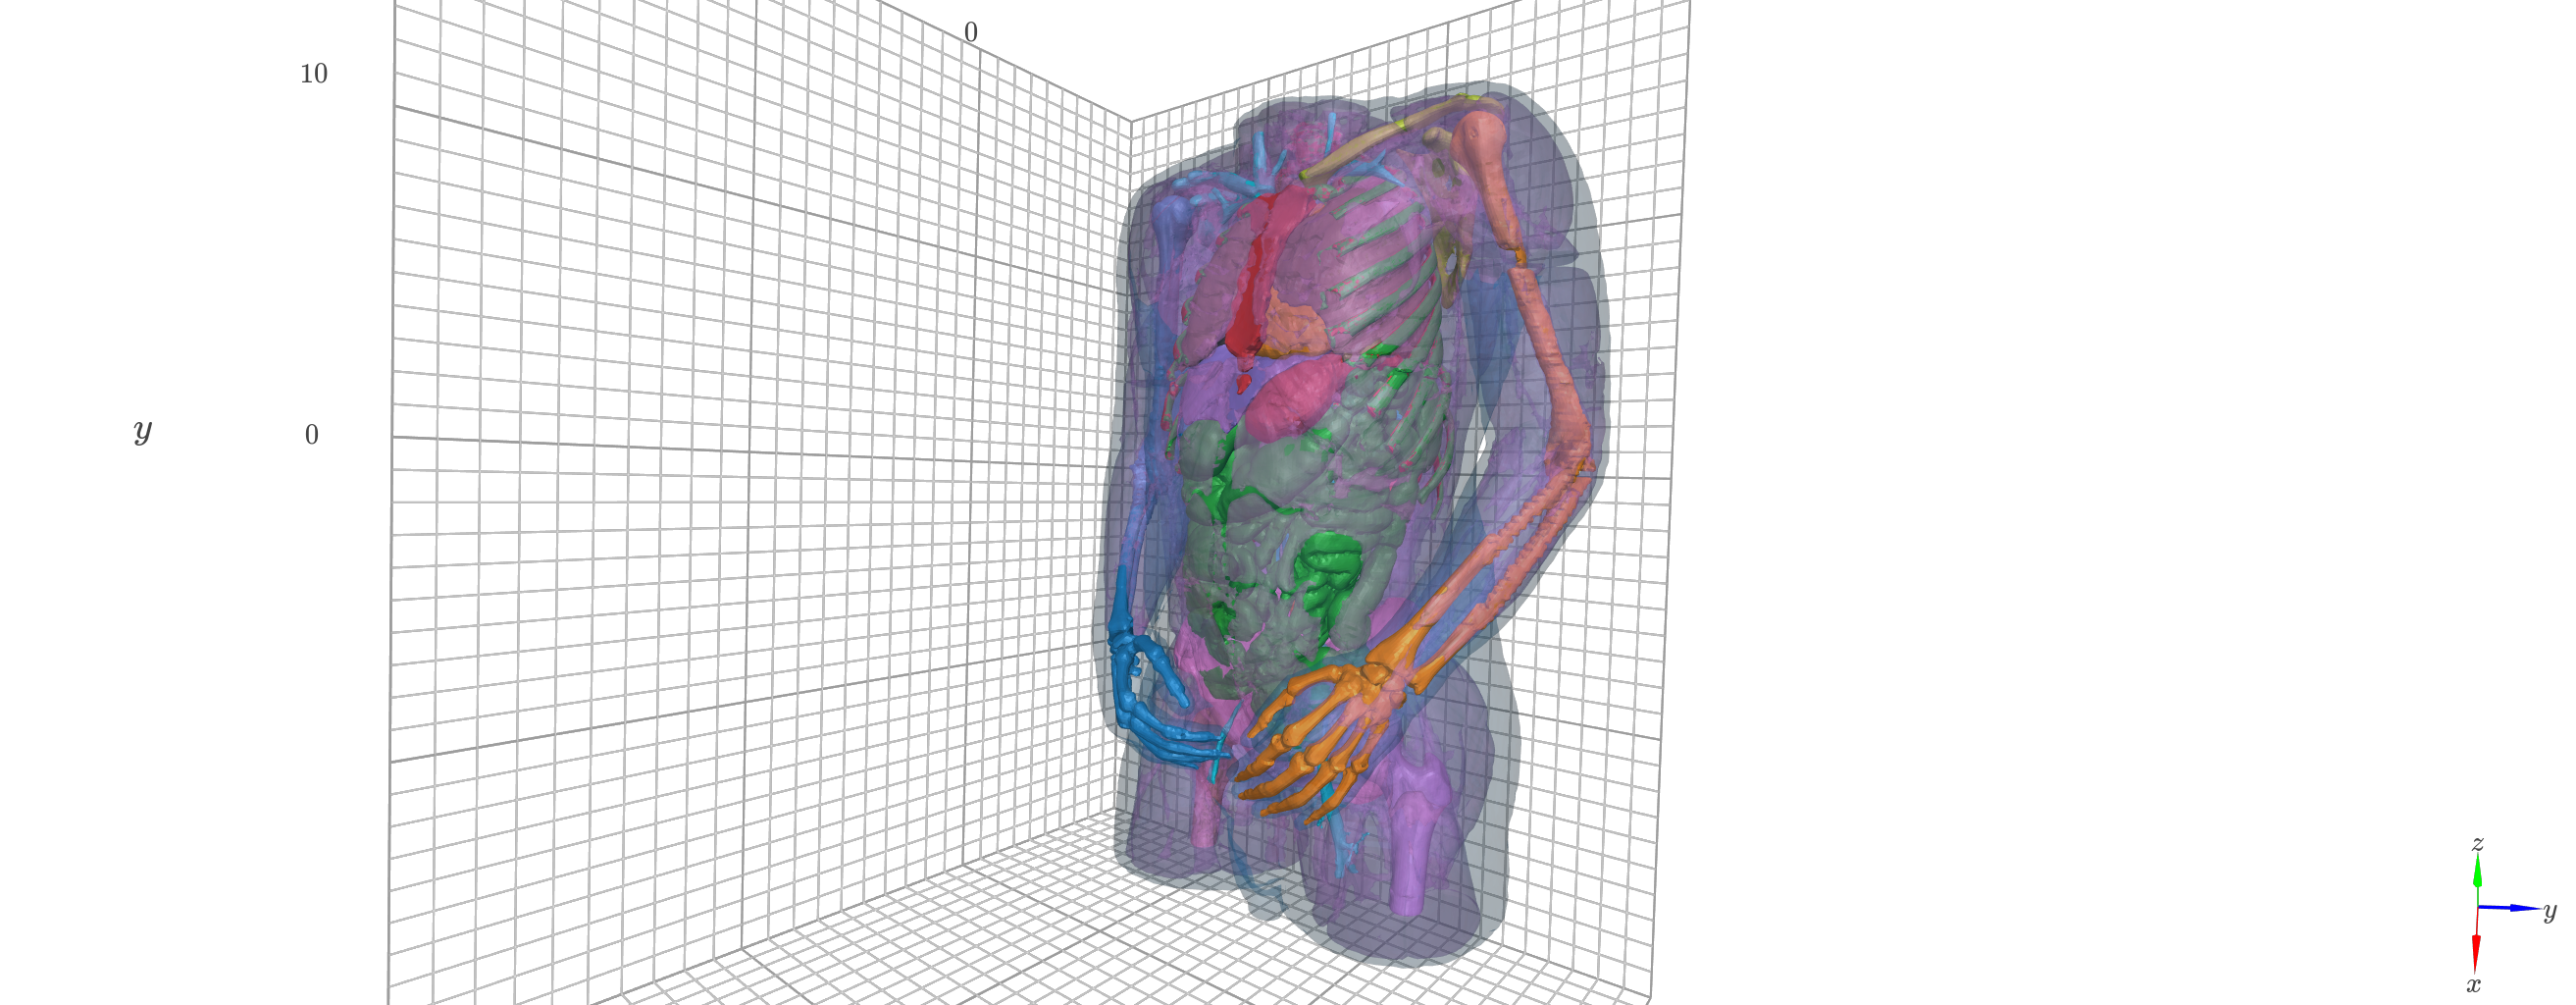

In [2]:
Image(filename="plots/VHP_model.png")

**Results:** The [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), between the two simulated images is **MAPE ????%**. The **[zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is ????%**. 
The **[Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is 0.????**. 
As MAPE is low (close to 0), SSIM is 0.???, and ZNCC is high (close to 100%), we can conclude that X-ray images simulated with gVirtualXRay on GPU in milliseconds are comparable to Monte Carlo simulations ran on supercomputers for days.

The calculations were performed on the following platform:

In [3]:
printSystemInfo()

OS:
	Linux 5.3.18-150300.59.43-default
	x86_64

CPU:
 	AMD Ryzen 7 3800XT 8-Core Processor

RAM:
	63 GB
GPU:
	Name: GeForce RTX 2080 Ti
	Drivers: 455.45.01
	Video memory: 11 GB


## Import packages

In [112]:
%matplotlib inline

import os # Locate files
from time import sleep

import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import matplotlib
# old_backend =  matplotlib.get_backend() 
# matplotlib.use("Agg")  # Prevent showing stuff

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

from scipy.stats import pearsonr # Compute the correlatio coefficient
from skimage.util import compare_images # Checkboard comparison between two images

from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape
# from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tifffile import imread, imsave # Load/Write TIFF files

import viewscad # Use OpenSCAD to create STL files

# import pyvista as pv # 3D visualisation
# from pyvista import themes

# import cma # Optimise the parameters of the noise model

import k3d
import random
import base64
from stl import mesh

import urllib, gzip # To download the phantom data, and extract the corresponding Z file


import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up
from utils import * # Code shared across more than one notebook
import cma # Optimisation

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

import sys

In [5]:
def standardisation(img):
    return (img - img.mean()) / img.std()

## Reference image

We first load the reference image from the [Visible Human Project](https://www.nlm.nih.gov/databases/download/vhp.html). You can find it at [https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Male-Images/radiological/xray8/x_vm_pe.Z](https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Male-Images/radiological/xray8/x_vm_pe.Z). When you download it, make sure to gunzip it!

In [6]:
if not os.path.exists("VHP"):
    os.mkdir("VHP")

if not os.path.exists("VHP/x_vm_pe.Z"):
    urllib.request.urlretrieve("https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Male-Images/radiological/xray8/x_vm_pe.Z", "VHP/x_vm_pe.Z")
        
if not os.path.exists("VHP/x_vm_pe"):

    gzip_file = gzip.open('VHP/x_vm_pe.Z') # use gzip.open instead of builtin open function
    file_content = gzip_file.read()
    f = open('VHP/x_vm_pe', 'wb')
    f.write(file_content)
    f.close()    

In [7]:
raw_reference = np.fromfile("VHP/x_vm_pe", dtype=np.uint8)
raw_reference.shape = (1536,1248)
raw_reference = np.rot90(raw_reference)

# Crop
y_max = 1000
raw_reference = raw_reference[:y_max]

In [8]:
imsave('gVirtualXRay_output_data/real_projection-VHP.tif', raw_reference.astype(np.single))

In [9]:
corrected_real_projection = raw_reference.astype(np.single) / 255.0

In [10]:
imsave('gVirtualXRay_output_data/corrected_real_projection-VHP.tif', corrected_real_projection.astype(np.single))

We plot the image using a linear look-up table and a power-law normalisation.

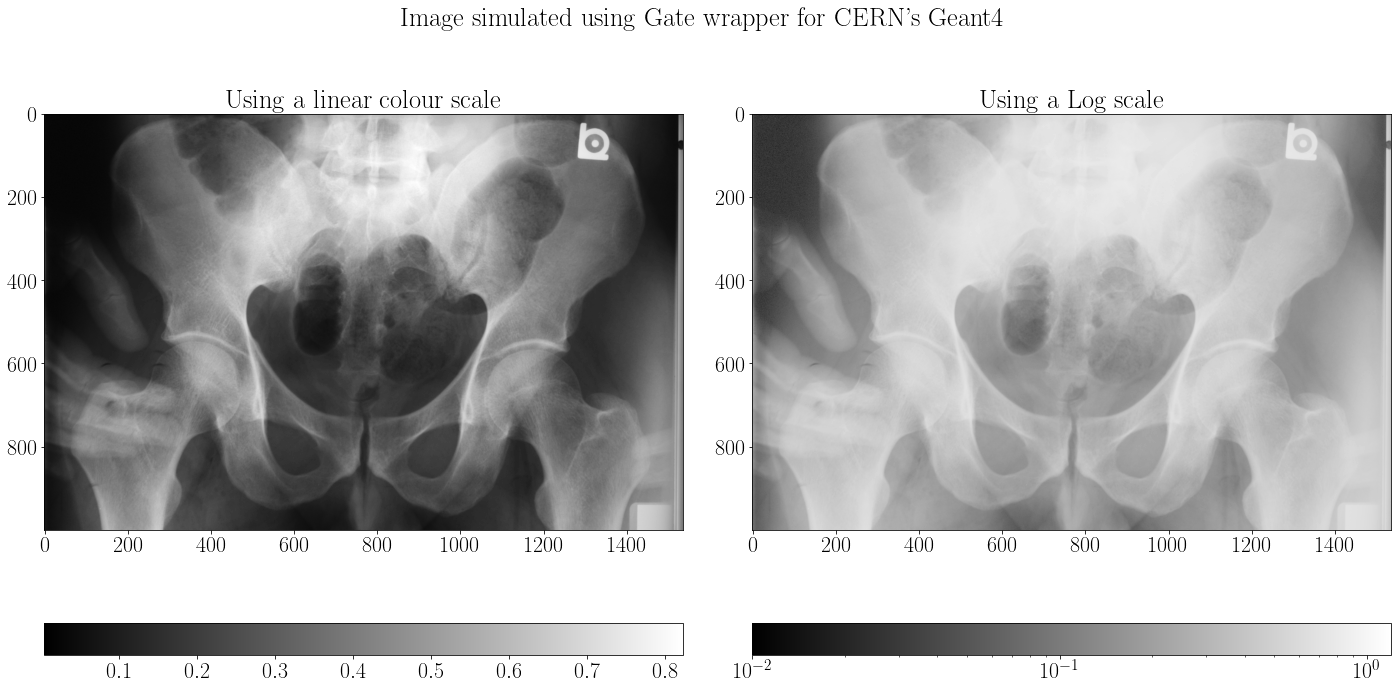

In [11]:
displayLinearPowerScales(corrected_real_projection,
                         "Image simulated using Gate wrapper for CERN's Geant4",
                         "plots/reference_from_Gate-VHP",
                         log=True)

Apply a log transformation

In [12]:
ground_truth = raw_reference
# log_ground_truth = np.log(ground_truth)
# ground_truth = standardisation(log_ground_truth)

# imsave('gVirtualXRay_output_data/ground_truth-VHP.tif', ground_truth.astype(np.single))

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [13]:
json2gvxr.initGVXR("notebook-8.json", "OPENGL")

Create an OpenGL context: 800x450


## X-ray source

We create an X-ray source. It is a point source.

In [14]:
json2gvxr.initSourceGeometry("notebook-8.json")

Set up the beam
	Source position: [0.0, -30.5, 150.0, 'cm']
	Source shape: PointSource


## Spectrum

The spectrum is polychromatic.

In [15]:
spectrum, unit, k, f = json2gvxr.initSpectrum("notebook-8.json", verbose=0)
energy_set = sorted(spectrum.keys())

count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])

params["Source"]["Beam"] {'kvp': 85, 'tube angle': 12, 'filter': [['Al', 3.2]]}
['Al', 3.2]


Plot the spectrum

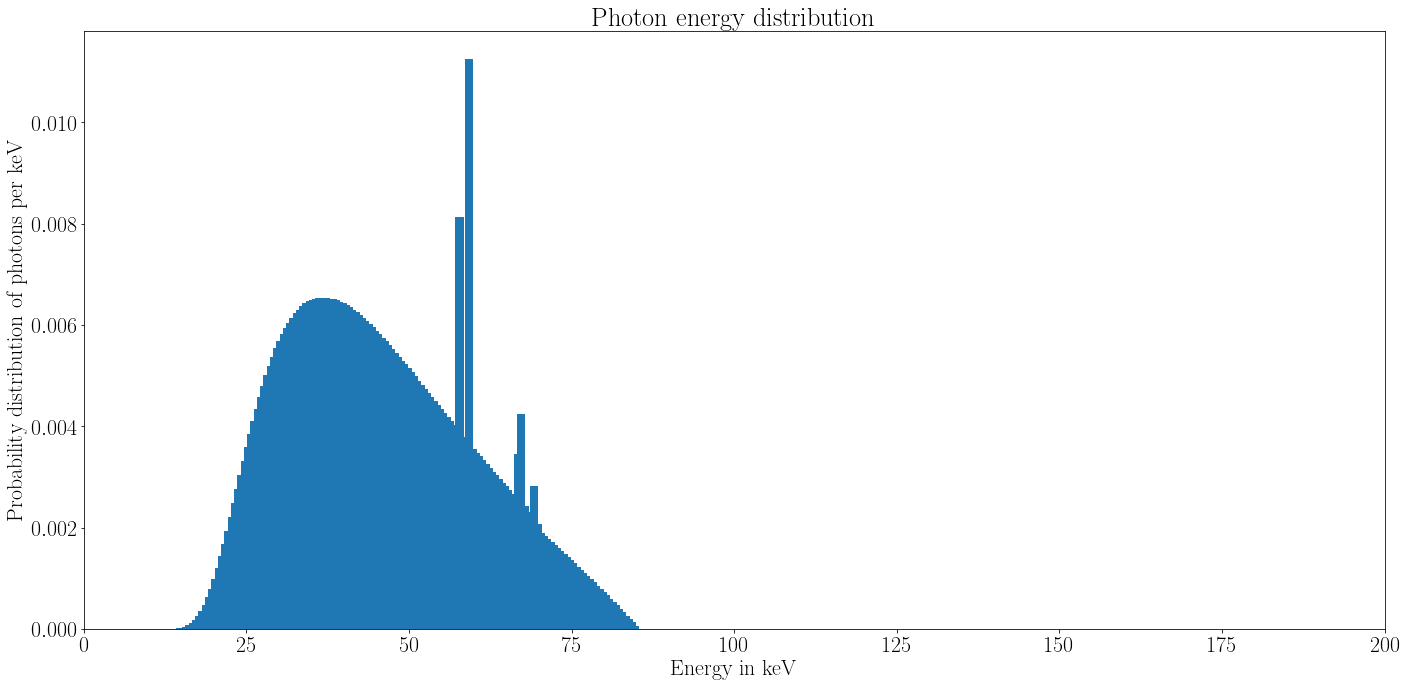

In [16]:
plotSpectrum(k, f, 'plots/spectrum-VHP')

## Detector

Create a digital detector

In [17]:
json2gvxr.initDetector("notebook-8.json")

Set up the detector
	Detector position: [0.0, -30.5, -20.5, 'cm']
	Detector up vector: [0, -1, 0]
	Detector number of pixels: [1536, 1248]
	Pixel spacing: [0.026347682927083334, 0.026347683, 'cm']


## Model the energy response of the detector

Load the energy response

In [18]:
# detector_response = np.loadtxt("Gate_data/responseDetector.txt")

Display the energy response

In [19]:
# plt.figure(figsize= (20,10))
# # plt.title("Detector response")
# plt.plot(detector_response[:,0] * 1000, detector_response[:,1] * 1000)
# plt.xlabel('Incident energy: E (in keV)')
# plt.ylabel('Detector energy response: $\\delta$(E) (in keV)')

# plt.tight_layout()

# plt.savefig('plots/detector_response-VHP.pdf')
# plt.savefig('plots/detector_response-VHP.png')

## Sample

We now load the models segmented from the Visible Human.

Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [20]:
json2gvxr.initSamples("notebook-8.json", verbose=0)

# Apply the scaling factor from pixels to cm

In [21]:
for anatomy in json2gvxr.params["Samples"]:
    label = anatomy["Label"]
    gvxr.scaleNode(label, 3.3, 3.3, 3.3)
    gvxr.applyCurrentLocalTransformation(label)

Visualise the virtual patient

In [22]:
# plot = k3d.plot()
# plot.background_color = 0xffffff

# for sample in json2gvxr.params["Samples"]:
    
#     label = sample["Label"]
    
#     fname = sample["Path"]

#     r, g, b, a = gvxr.getAmbientColour(label)
#     R = math.floor(255*r)
#     G = math.floor(255*g)
#     B = math.floor(255*b)
#     A = math.floor(255*a)

#     k3d_color = 0;
#     k3d_color |= (R & 255) << 16;
#     k3d_color |= (G & 255) << 8;
#     k3d_color |= (B & 255);

#     mesh_from_stl_file = mesh.Mesh.from_file(fname)

#     if label == "skin":
#         opacity = 0.2
#     elif label == "muscles":
#         opacity = 0.3
#     else:
#         opacity = 1
#     geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
#                           range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
#                           color=k3d_color, 
#                           wireframe=False, 
#                           flat_shading=False,
#                           name=fname,
#                           opacity=opacity)

#     plot += geometry   

# plot.display()
# plot.camera = [17.757085561576094, -0.5941481609904308, 25.327896522760597, -0.2824745178222656, -1.2793889045715332, 0.587073564529419, -0.00450313545724278, 0.9990136450056702, 0.04417531962005856]

In [23]:
fname = 'plots/VHP_model.png'
if not os.path.isfile(fname):

    sleep(10)
    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    sleep(10)
    
    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)

## Simulation with the default values

In [24]:
# Backup the transformation matrix
global_matrix_backup = gvxr.getSceneTransformationMatrix()

In [25]:
def getXRayImage():
    global total_energy_in_MeV

    # Compute the X-ray image
    xray_image = np.array(gvxr.computeXRayImage())
    
    # Apply the ROI
    xray_image = xray_image[:y_max]
    
    # Flat-field
#     xray_image /= total_energy_in_MeV
    
    # Negative
    # x_ray_image = 1.0 - x_ray_image
    return xray_image #np.ones(xray_image.shape).astype(np.single) - xray_image

In [26]:
xray_image = getXRayImage()

In [27]:
# gvxr.enableArtefactFilteringOnCPU()
gvxr.enableArtefactFilteringOnGPU()
# gvxr.disableArtefactFiltering() # Spere inserts are missing with GPU integration when a outer surface is used for the matrix

In [28]:
# total_energy_in_keV = 0.0
# for energy, count in zip(energy_set, count_set):
#     effective_energy = find_nearest(detector_response[:,0], energy / 1000, detector_response[:,1])

#     total_energy_in_keV += effective_energy * count
    
total_energy_in_MeV = gvxr.getTotalEnergyWithDetectorResponse()

In [29]:
xray_image = getXRayImage()

In [30]:
gvxr.displayScene()
gvxr.useNegative()

gvxr.setZoom(1569.6787109375)
gvxr.setSceneRotationMatrix([-0.3190782964229584,  -0.15100032091140747, -0.9356207251548767,  0.0,
                              0.002036974299699068, 0.987101674079895,   -0.16000667214393616, 0.0,
                              0.9477221369743347,  -0.05296054854989052, -0.31466084718704224, 0.0, 
                              0.0,                  0.0,                  0.0,                 1.0])

gvxr.setWindowBackGroundColour(0.5, 0.5, 0.5)

gvxr.displayScene()

In [31]:
# gvxr.renderLoop()

In [32]:
# print(gvxr.getZoom())
# print(gvxr.getSceneRotationMatrix())

In [33]:
screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

In [34]:
fname = 'VHP/default-screenshot.png'
if True:#not os.path.isfile(fname):

    plt.imsave(fname, screenshot)

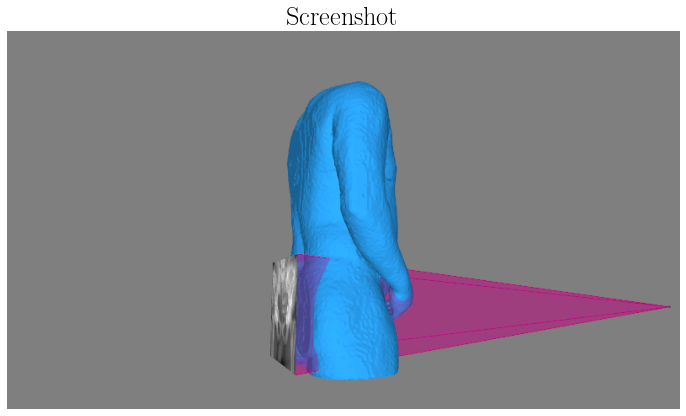

In [35]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/default-screenshot-beam-on-VHP.pdf')
plt.savefig('plots/default-screenshot-beam-on-VHP.png')

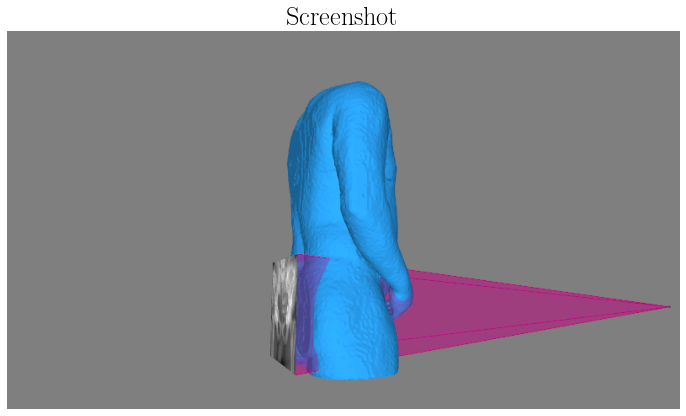

In [36]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/default-screenshot-beam-on-VHP.pdf')
plt.savefig('plots/default-screenshot-beam-on-VHP.png')

In [37]:
def logImage(xray_image: np.array, min_val: float, max_val: float) -> np.array:
    
    log_epsilon = 1.0e-9

    shift_filter = -math.log(min_val + log_epsilon)
    
    if min_val != max_val:
        scale_filter = 1.0 / (math.log(max_val + log_epsilon) - math.log(min_val + log_epsilon))
    else:
        scale_filter = 1.0

    corrected_image = np.log(xray_image + log_epsilon)

    return (corrected_image + shift_filter) * scale_filter

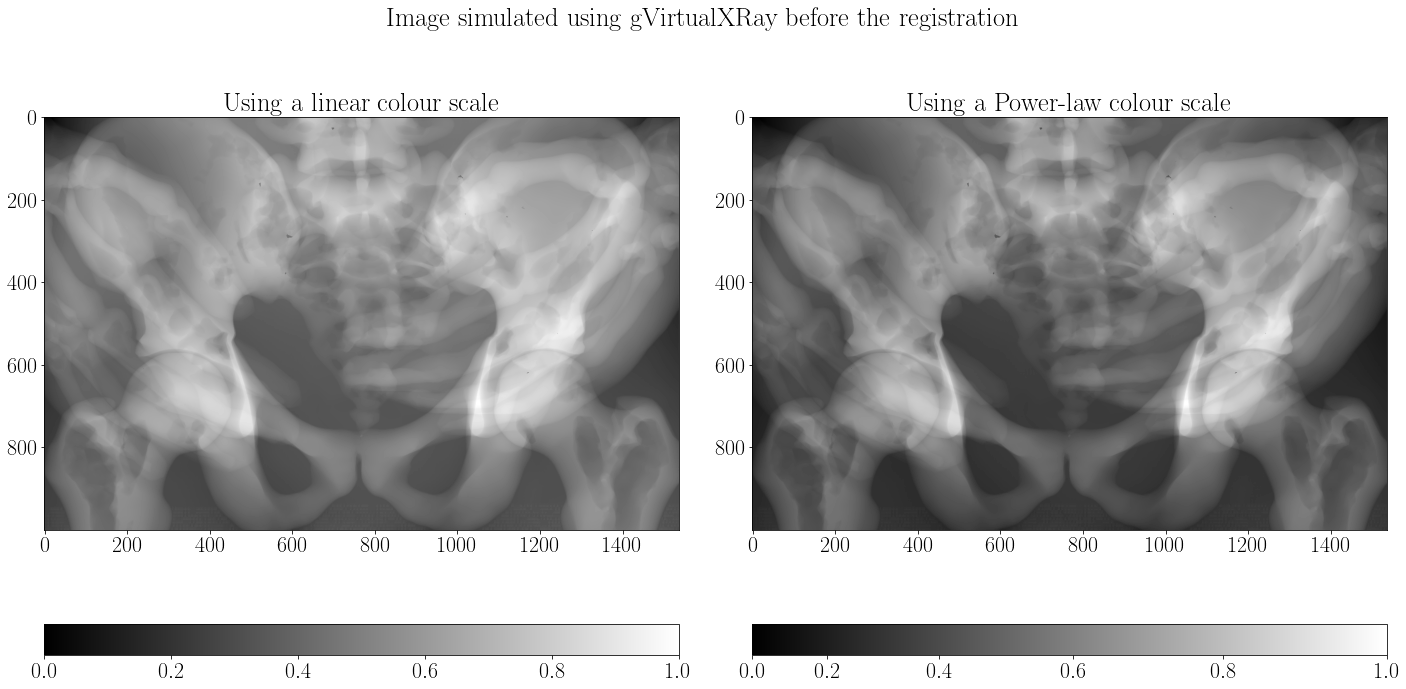

In [39]:
displayLinearPowerScales(1 - logImage(xray_image, xray_image.min(), xray_image.max()),
                         "Image simulated using gVirtualXRay before the registration",
                         "plots/gVirtualXRay-before_registration-VHP",
                         log=False)

## Registration

The SSD, DOD and rotation of the virtual patient are unknown. We estimate them to register a simulated X-ray image on a real radiograph.

In [40]:
def gainAndBias(image: np.array, gain: float, bias: float) -> np.array:
    return image * gain + bias

In [41]:
def powerLaw(image: np.array, gamma: float) -> np.array:
    invGamma = 1.0 / gamma
    return image ** invGamma

In [42]:
roi_ground_truth_min = ground_truth.min()
roi_ground_truth_max = ground_truth.max()
standardised_roi_ground_truth = standardisation(ground_truth)

imsave('gVirtualXRay_output_data/standardised_roi_ground_truth-VHP.tif', standardised_roi_ground_truth.astype(np.single))

In [131]:
def updateXRayImage(x):
    
    
    # Backup the transformation matrix
    matrix_backup = gvxr.getSceneTransformationMatrix()

    # Orientation of the sample
    sample_rotation_angle1 = x[0]
    sample_rotation_angle2 = x[1]

    gvxr.rotateScene(sample_rotation_angle1, 1, 0, 0)
    gvxr.rotateScene(sample_rotation_angle2, 0, 1, 0)

    # Position of the source
    source_position_x = x[2]
    source_position_y = x[3]
    source_position_z = x[4]
    
    gvxr.setSourcePosition(
        source_position_x,
        source_position_y,
        source_position_z,
        "cm"
    )
    
    # Position of the detector
    det_position_x = x[5]
    det_position_y = x[6]
    det_position_z = x[7]
    
    gvxr.setDetectorPosition(
        det_position_x,
        det_position_y,
        det_position_z,
        "cm"
    )

    # Orientation of the detector
#     det_rotation_angle1 = x[8]
#     det_rotation_angle2 = x[9]

    # Compute the X-ray image
    xray_image = getXRayImage()

#     gvxr.displayScene()
#     screenshot = gvxr.takeScreenshot()

    # Restore the transformation matrix
    gvxr.setSceneTransformationMatrix(matrix_backup)

    return xray_image #, screenshot

In [75]:
def objectiveFunction(x):
    
    global ground_truth, standardised_roi_ground_truth
    global best_fitness, best_fitness_id, fitness_function_call_id, evolution_zncc, evolution_parameters


    xray_image, screenshot = updateXRayImage(x)
    
    offset_x = 8
    
#     c1 = x[offset_x + 0]
#     gain1 = x[offset_x + 1]
#     bias1 = x[offset_x + 2]
#     corrected_image_1 = gainAndBias(xray_image, gain1, bias1)
    
#     c2 = x[offset_x + 3]
#     gain2 = x[offset_x + 4]
#     bias2 = x[offset_x + 5]
#     corrected_image_2 = gainAndBias(xray_image, gain2, bias2)
#     min_val = corrected_image_2.min()
#     max_val = corrected_image_2.max()

#     c3 = x[offset_x + 6]
#     gain3 = x[offset_x + 7]
#     bias3 = x[offset_x + 8]
#     gamma = x[offset_x + 9]
#     corrected_image_3 = gainAndBias(xray_image, gain3, bias2)
   
#     corrected_xray_image = c1 * corrected_image_1 + \
#                            c2 * logImage(corrected_image_2, min_val, max_val) #+ \
#                            c3 * powerLaw(corrected_image_3, gamma)
    
    
    corrected_xray_image = logImage(xray_image, xray_image.min(), xray_image.max())
    corrected_xray_image = 1 - corrected_xray_image
    standardised_corrected_xray_image = standardisation(corrected_xray_image)
    
    zncc = np.mean(standardised_roi_ground_truth * standardised_corrected_xray_image)
    mae = np.mean(np.abs(standardised_roi_ground_truth - standardised_corrected_xray_image))
#     rmse = math.sqrt(np.mean(np.square(ground_truth - corrected_xray_image)))
#     ssim_value = ssim(ground_truth, corrected_xray_image, data_range=ground_truth - ground_truth)
#     mape_value = mape(ground_truth, corrected_xray_image)
    
#     dssim = (1.0 - ssim_value) / 2.0
#     dzncc = (1.0 - zncc) / 2.0
    
    objective = mae
#     objective = dssim
    
    if best_fitness > objective:
        
        imsave("gVirtualXRay_output_data/HIPS_xray_" + str(best_fitness_id) + ".tif", standardised_corrected_xray_image.astype(np.single))
        imsave("gVirtualXRay_output_data/HIPS_screenshot_" + str(best_fitness_id) + ".tif",(255 * np.array(screenshot)).astype(np.uint8)
)
    
        evolution_zncc.append([fitness_function_call_id, zncc])
        evolution_parameters.append(np.array([fitness_function_call_id, x], dtype=np.object).flatten())
        
        best_fitness = objective
        best_fitness_id += 1
    
    fitness_function_call_id += 1
   
    return objective

In [124]:
def objectiveFunctions(x):
    
    global ground_truth, standardised_roi_ground_truth
    global best_fitness, best_fitness_id, fitness_function_call_id, evolution_zncc, evolution_parameters


#     xray_image, screenshot = updateXRayImage(x)
    xray_image = updateXRayImage(x)
    
    offset_x = 8
    
#     c1 = x[offset_x + 0]
#     gain1 = x[offset_x + 1]
#     bias1 = x[offset_x + 2]
#     corrected_image_1 = gainAndBias(xray_image, gain1, bias1)
    
#     c2 = x[offset_x + 3]
#     gain2 = x[offset_x + 4]
#     bias2 = x[offset_x + 5]
#     corrected_image_2 = gainAndBias(xray_image, gain2, bias2)
#     min_val = corrected_image_2.min()
#     max_val = corrected_image_2.max()

#     c3 = x[offset_x + 6]
#     gain3 = x[offset_x + 7]
#     bias3 = x[offset_x + 8]
#     gamma = x[offset_x + 9]
#     corrected_image_3 = gainAndBias(xray_image, gain3, bias2)
   
#     corrected_xray_image = c1 * corrected_image_1 + \
#                            c2 * logImage(corrected_image_2, min_val, max_val) #+ \
#                            c3 * powerLaw(corrected_image_3, gamma)
    
    
    corrected_xray_image = logImage(xray_image, xray_image.min(), xray_image.max())
    corrected_xray_image = 1 - corrected_xray_image
    standardised_corrected_xray_image = standardisation(corrected_xray_image)
    
    objectives = []
    zncc = np.mean(standardised_roi_ground_truth * standardised_corrected_xray_image)
    mae = np.mean(np.abs(standardised_roi_ground_truth - standardised_corrected_xray_image))
    rmse = math.sqrt(np.mean(np.square(ground_truth - corrected_xray_image)))
    ssim_value = ssim(ground_truth, corrected_xray_image, data_range=ground_truth - ground_truth)
    mape_value = mape(ground_truth, corrected_xray_image)
    
    dssim = (1.0 - ssim_value) / 2.0
    dzncc = (1.0 - zncc) / 2.0

    objectives.append(dzncc)
    objectives.append(mae)
    objectives.append(rmse)
    objectives.append(dssim)
    objectives.append(mape_value)

    objective = dzncc
    
#     if best_fitness > objective:
        
#         imsave("gVirtualXRay_output_data/HIPS_xray_" + str(best_fitness_id) + ".tif", standardised_corrected_xray_image.astype(np.single))
#         imsave("gVirtualXRay_output_data/HIPS_screenshot_" + str(best_fitness_id) + ".tif",(255 * np.array(screenshot)).astype(np.uint8)
# )
    
#         evolution_zncc.append([fitness_function_call_id, zncc])
#         evolution_parameters.append(np.array([fitness_function_call_id, x], dtype=np.object).flatten())
        
#         best_fitness = objective
#         best_fitness_id += 1
    
#     fitness_function_call_id += 1
   
    return objectives

In [132]:
json2gvxr.initDetector("notebook-8.json")
json2gvxr.initSourceGeometry("notebook-8.json")
source_position = gvxr.getSourcePosition("cm")
detector_position = gvxr.getDetectorPosition("cm")

# Restore the transformation matrix
gvxr.setSceneTransformationMatrix(global_matrix_backup)

x_init = [
    # Orientation of the sample
    0.0, 0.0,

    # Position of the source
    source_position[0],
    source_position[1],
    source_position[2],

    # Position of the detector
    detector_position[0],
    detector_position[1],
    detector_position[2]#,

    # Orientation of the detector
    #     det_rotation_angle1 = x[8]
    #     det_rotation_angle2 = x[9]

#         1.0 / 3.0, # c1
#         1.0, # gain1
#         0.0, # bias1

#         1.0 / 3.0, # c2
#         1.0, # gain2
#         0.0#, # bias2

#         1.0 / 3.0, # c3
#         1.0, # gain3
#         0.0, # bias3
#         2.0 # gamma
]

Set up the detector
	Detector position: [0.0, -30.5, -20.5, 'cm']
	Detector up vector: [0, -1, 0]
	Detector number of pixels: [1536, 1248]
	Pixel spacing: [0.026347682927083334, 0.026347683, 'cm']
Set up the beam
	Source position: [0.0, -30.5, 150.0, 'cm']
	Source shape: PointSource


In [133]:
xl = [
            -angle_offset, -angle_offset, 
            source_position[0] - pos_offset, source_position[1] - pos_offset, source_position[2] - pos_offset,
            detector_position[0] - pos_offset, detector_position[1] - pos_offset, detector_position[2] - pos_offset#,
#             -90, -90, 
#             -10.0,
#             -10.0,
#             -10.0,

#             -10.0,
#             0.0,
#             0.0#,

#             -10.0,
#             -10.0,
#             -10.0,
#             0.0
        ]

xu = [
            angle_offset, angle_offset, 
            source_position[0] + pos_offset, source_position[1] + pos_offset, source_position[2] + pos_offset,
            detector_position[0] + pos_offset, detector_position[1] + pos_offset, detector_position[2] + pos_offset #,
#             90, 90, 
#             10.0,
#             10.0,
#             10.0,

#             10.0,
#             10.0,
#             10.0#,

#             10.0,
#             10.0,
#             10.0,
#             100.0
        ]

In [134]:
from pymoo.core.problem import Problem


from pymoo.core.problem import ElementwiseProblem

class MyMultiObjectiveProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=len(x_init),
                         n_obj=5,
                         n_constr=0,
                         xl=xl,
                         xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = objectiveFunctions(x)

# problem = MyProblem()



# class MyMultiObjectiveProblem(Problem):

#     def __init__(self):
#         super().__init__(n_var=len(x_init), n_obj=5, n_constr=0, xl=xl, xu=xu)

#     def _evaluate(self, x, out, *args, **kwargs):
#         out["F"] = objectiveFunctions(x)

In [ ]:
from pymoo.factory import get_visualization, get_reference_directions
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.optimize import minimize
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_termination

n_objs = 5
n_partitions = 6

ref_dirs = get_reference_directions("das-dennis", n_objs, n_partitions=n_partitions)

problem = MyMultiObjectiveProblem()

pop_size = 2 * ref_dirs.shape[0]

algorithm = NSGA3(
#     pop_size=pop_size,
#     n_offsprings=int(pop_size*0.05),
    eliminate_duplicates=True,
    ref_dirs=ref_dirs
)

# termination = get_termination("n_gen", pop_size)


res = minimize(problem,
               algorithm,
#                termination,
               seed=1,
               save_history=True,
               verbose=True)

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     210 |      16 |            - |            -
    2 |     420 |      19 |  0.031966128 |        ideal
    3 |     630 |      14 |  0.046756280 |        ideal
    4 |     840 |      12 |  0.107041406 |        ideal
    5 |    1050 |      15 |  0.046879766 |        ideal
    6 |    1260 |      17 |  0.253653470 |        nadir
    7 |    1470 |      15 |  0.051376429 |        ideal
    8 |    1680 |      20 |  0.144720147 |        ideal
    9 |    1890 |      22 |  0.011923131 |        ideal
   10 |    2100 |      18 |  0.065032381 |        ideal
   11 |    2310 |      16 |  0.049368893 |        ideal
   12 |    2520 |      17 |  0.022785334 |        ideal
   13 |    2730 |      17 |  0.078893861 |        ideal
   14 |    2940 |      19 |  0.073124766 |        ideal
   15 |    3150 |      16 |  0.023314624 |        ideal
   16 |    3360 |      14 |  0.103414127 |        ideal
   17 |    3570 |      20 |  0.056275253 |      

In [80]:
# from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.optimize import minimize
# from pymoo.factory import get_sampling, get_crossover, get_mutation, get_termination

# problem = MyMultiObjectiveProblem()

# algorithm = NSGA2(
#     pop_size=40,
#     n_offsprings=10,
#     sampling=get_sampling("real_random"),
#     crossover=get_crossover("real_sbx", prob=0.9, eta=15),
#     mutation=get_mutation("real_pm", eta=20),
#     eliminate_duplicates=True
# )

# termination = get_termination("n_gen", 40)


# res = minimize(problem,
#                algorithm,
#                termination,
#                seed=1,
#                save_history=True,
#                verbose=True)

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      40 |       8 |            - |            -


<ipython-input-76-b0d914059665>:63: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  evolution_parameters.append(np.array([fitness_function_call_id, x], dtype=np.object).flatten())


    2 |      50 |      11 |  0.015937624 |        ideal
    3 |      60 |      12 |  0.034803377 |            f


<ipython-input-76-b0d914059665>:63: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  evolution_parameters.append(np.array([fitness_function_call_id, x], dtype=np.object).flatten())


    4 |      70 |      13 |  0.156613257 |        ideal
    5 |      80 |      14 |  0.012980365 |        nadir
    6 |      90 |      18 |  0.077365036 |        nadir
    7 |     100 |      19 |  0.740881251 |        nadir
    8 |     110 |      13 |  0.062332795 |        ideal
    9 |     120 |      15 |  0.039193225 |        ideal
   10 |     130 |      19 |  0.033335460 |            f
   11 |     140 |      21 |  0.404286271 |        nadir
   12 |     150 |      19 |  0.155329437 |        ideal
   13 |     160 |      21 |  0.518576854 |        nadir
   14 |     170 |      24 |  0.237340155 |        nadir
   15 |     180 |      25 |  0.054705603 |        nadir
   16 |     190 |      27 |  0.009536594 |        ideal
   17 |     200 |      28 |  0.022759589 |            f
   18 |     210 |      29 |  0.018658316 |        ideal
   19 |     220 |      29 |  0.00000E+00 |            f
   20 |     230 |      31 |  0.001123205 |            f
   21 |     240 |      30 |  0.061443799 |      

<ipython-input-76-b0d914059665>:63: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  evolution_parameters.append(np.array([fitness_function_call_id, x], dtype=np.object).flatten())


   30 |     330 |      40 |  0.115402750 |        ideal
   31 |     340 |      40 |  0.000786290 |            f
   32 |     350 |      40 |  0.110361303 |        nadir
   33 |     360 |      40 |  0.012092314 |            f
   34 |     370 |      40 |  0.019173706 |        ideal
   35 |     380 |      40 |  0.007947915 |        ideal
   36 |     390 |      40 |  0.002531049 |            f


<ipython-input-76-b0d914059665>:63: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  evolution_parameters.append(np.array([fitness_function_call_id, x], dtype=np.object).flatten())


   37 |     400 |      40 |  0.008950876 |        ideal
   38 |     410 |      39 |  0.076054968 |        nadir
   39 |     420 |      40 |  6.12481E-06 |            f
   40 |     430 |      40 |  0.013969601 |        ideal


In [104]:
best_dzncc_id = np.argmin(res.F[:,0])
best_mae_id = np.argmin(res.F[:,1])
best_rmse_id = np.argmin(res.F[:,2])
best_dssim_id = np.argmin(res.F[:,3])
best_mape_id = np.argmin(res.F[:,4])

print("Lowest DZNCC:", res.F[:,0].min(), best_dzncc_id, res.X[best_dzncc_id])
print("Lowest MAE:", res.F[:,1].min(), best_mae_id, res.X[best_mae_id])
print("Lowest RMSE:", res.F[:,2].min(), best_rmse_id, res.X[best_rmse_id])
print("Lowest DSSIM:", res.F[:,3].min(), best_dssim_id, res.X[best_dssim_id])
print("Lowest MAPE:", res.F[:,4].min(), best_mape_id, res.X[best_mape_id])

Lowest DZNCC: 0.214355704131161 8 [  3.25933184   1.23672207 -19.98362497 -41.76493621 140.79710683
   0.24197445 -32.08065288  -2.13534522]
Lowest MAE: 0.7417436416200976 5 [  1.95245978   1.23672207 -19.98362497 -41.76493621 167.93606302
   0.24197445 -30.95903169  -2.13534522]
Lowest RMSE: 97.15194684803488 6 [ -4.64210312  -2.72824907   1.39009463 -23.2386377  169.50252268
   3.36628785 -21.77419674 -34.42647951]
Lowest DSSIM: 0.4999935346605006 4 [  3.26450471  -3.01044752   5.51361898 -37.72590709 135.6350851
  -0.1358972  -16.57825895  -1.39436311]
Lowest MAPE: 0.9856137208979985 3 [  3.60610525   1.85056469  -3.86692496 -45.1816867  130.08022026
  -7.54990819 -22.85074963 -39.59217162]


In [ ]:
best_dzncc_id = np.argmin(res.F[:,0])
best_mae_id = np.argmin(res.F[:,1])
best_rmse_id = np.argmin(res.F[:,2])
best_dssim_id = np.argmin(res.F[:,3])
best_mape_id = np.argmin(res.F[:,4])

print("Lowest DZNCC:", res.F[:,0].min(), best_dzncc_id, res.X[best_dzncc_id])
print("Lowest MAE:", res.F[:,1].min(), best_mae_id, res.X[best_mae_id])
print("Lowest RMSE:", res.F[:,2].min(), best_rmse_id, res.X[best_rmse_id])
print("Lowest DSSIM:", res.F[:,3].min(), best_dssim_id, res.X[best_dssim_id])
print("Lowest MAPE:", res.F[:,4].min(), best_mape_id, res.X[best_mape_id])

In [ ]:
np.savetxt("gVirtualXRay_output_data/res_X.dat", res["X"])
np.savetxt("gVirtualXRay_output_data/res_F.dat", res["F"])

In [ ]:
xray_image_dzncc, screenshot_dzncc = updateXRayImage(res.X[best_dzncc_id])
xray_image_mae, screenshot_mae = updateXRayImage(res.X[best_mae_id])
xray_image_rmse, screenshot_rmse = updateXRayImage(res.X[best_rmse_id])
xray_image_dssim, screenshot_dssim = updateXRayImage(res.X[best_dssim_id])
xray_image_mape, screenshot_mape = updateXRayImage(res.X[best_mape_id])

In [ ]:
xray_image_dzncc = logImage(xray_image_dzncc, xray_image_dzncc.min(), xray_image_dzncc.max())
xray_image_dzncc = 1 - xray_image_dzncc
xray_image_dzncc = standardisation(xray_image_dzncc)

xray_image_mae = logImage(xray_image_mae, xray_image_mae.min(), xray_image_mae.max())
xray_image_mae = 1 - xray_image_mae
xray_image_mae = standardisation(xray_image_mae)

xray_image_rmse = logImage(xray_image_rmse, xray_image_rmse.min(), xray_image_rmse.max())
xray_image_rmse = 1 - xray_image_rmse
xray_image_rmse = standardisation(xray_image_rmse)

xray_image_dssim = logImage(xray_image_dssim, xray_image_dssim.min(), xray_image_dssim.max())
xray_image_dssim = 1 - xray_image_dssim
xray_image_dssim = standardisation(xray_image_dssim)

xray_image_mape = logImage(xray_image_mape, xray_image_mape.min(), xray_image_mape.max())
xray_image_mape = 1 - xray_image_mape
xray_image_mape = standardisation(xray_image_mape)

In [ ]:
plt.figure(figsize=(20,6))

ax = plt.subplot(2, 5, 1)
ax.set_title("Best DZNCC")
ax.imshow(xray_image_dzncc, cmap="gray")

ax = plt.subplot(2, 5, 2)
ax.set_title("Best MAE")
ax.imshow(xray_image_mae, cmap="gray")

ax = plt.subplot(2, 5, 3)
ax.set_title("Best RMSE")
ax.imshow(xray_image_rmse, cmap="gray")

ax = plt.subplot(2, 5, 4)
ax.set_title("Best DSSIM")
ax.imshow(xray_image_dssim, cmap="gray")

ax = plt.subplot(2, 5, 5)
ax.set_title("Best MAPE")
ax.imshow(xray_image_mape, cmap="gray")

n_tiles=(5,5)
comp_equalized = compare_images(standardised_roi_ground_truth, xray_image_mae, method='checkerboard', n_tiles=n_tiles)
ax = plt.subplot(2, 5, 6)
ax.imshow(comp_equalized, cmap="gray")

comp_equalized = compare_images(standardised_roi_ground_truth, xray_image_rmse, method='checkerboard', n_tiles=n_tiles)
ax = plt.subplot(2, 5, 7)
ax.imshow(comp_equalized, cmap="gray")

comp_equalized = compare_images(standardised_roi_ground_truth, xray_image_rmse, method='checkerboard', n_tiles=n_tiles)
ax = plt.subplot(2, 5, 8)
ax.imshow(comp_equalized, cmap="gray")

comp_equalized = compare_images(standardised_roi_ground_truth, xray_image_dssim, method='checkerboard', n_tiles=n_tiles)
ax = plt.subplot(2, 5, 9)
ax.imshow(comp_equalized, cmap="gray")

comp_equalized = compare_images(standardised_roi_ground_truth, xray_image_mape, method='checkerboard', n_tiles=n_tiles)
ax = plt.subplot(2, 5, 10)
ax.imshow(comp_equalized, cmap="gray")


In [ ]:
from pymoo.visualization.scatter import Scatter

plot = Scatter(figsize=(50, 50))
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.5)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

In [53]:
if False: #os.path.exists("gVirtualXRay_output_data/HIPS_evolution_parameters.dat"):
    source_position = [0,0,0]
    detector_position = [0,0,0]
    source_position[0], source_position[1], source_position[2], detector_position[0], detector_position[1], detector_position[2], c1, gain1, bias1, c2, gain2, bias2, c3, gain3, bias3, gamma = np.loadtxt("gVirtualXRay_output_data/HIPS.dat")
    evolution_zncc = np.loadtxt("gVirtualXRay_output_data/HIPS_evolution_zncc.dat")
    evolution_parameters = np.loadtxt("gVirtualXRay_output_data/HIPS_evolution_parameters.dat")

# CMA-ES
else:

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-6)
    opts['tolx'] = 1e-6
    

        
    pos_offset = 20
    angle_offset = 5
    opts['bounds'] = [xl, xu]

    opts['CMA_stds'] = []

    for min_val, max_val in zip(opts['bounds'][0], opts['bounds'][1]):
        opts['CMA_stds'].append(abs(max_val - min_val) * 0.5)

    best_fitness = sys.float_info.max
    best_fitness_id = 0
    fitness_function_call_id = 0
    evolution_zncc = []
    evolution_parameters = []

    res = cma.fmin(objectiveFunction,
              x_init,
              0.5,
              opts,
              restarts=1)
    
    print(res)
    print(res[0])
#     sample_rotation_angle1, sample_rotation_angle2, source_position[0], source_position[1], source_position[2], detector_position[0], detector_position[1], detector_position[2], c1, gain1, bias1, c2, gain2, bias2, c3, gain3, bias3, gamma = res[0]
    sample_rotation_angle1, sample_rotation_angle2, source_position[0], source_position[1], source_position[2], detector_position[0], detector_position[1], detector_position[2] = res[0]


    # Save best parameters from the optimiser
    np.savetxt("gVirtualXRay_output_data/HIPS.dat",
               #[sample_rotation_angle1, sample_rotation_angle2, source_position[0], source_position[1], source_position[2], detector_position[0], detector_position[1], detector_position[2], c1, gain1, bias1, c2, gain2, bias2, c3, gain3, bias3, gamma],
#                header='source_position_x,source_position_y,source_position_z,detector_position_x,detector_position_y,detector_position_z,c1,gain1,bias1,c2,gain2,bias2,c3,gain3,bias3,gamma')
               [sample_rotation_angle1, sample_rotation_angle2, source_position[0], source_position[1], source_position[2], detector_position[0], detector_position[1], detector_position[2]],
               header='sample_rotation_angle1, sample_rotation_angle2,source_position_x,source_position_y,source_position_z,detector_position_x,detector_position_y,detector_position_z')

    # Save the list of zncc for plotting
    evolution_zncc = np.array(evolution_zncc)
    np.savetxt("gVirtualXRay_output_data/HIPS_evolution_zncc.dat", evolution_zncc, header='t,ZNCC')

    # Save the list of parameters for plotting
    evolution_parameters = np.array(evolution_parameters)
    np.savetxt("gVirtualXRay_output_data/HIPS_evolution_parameters.dat",
               evolution_parameters, 
#                header='t,sample_rotation_angle1, sample_rotation_angle2,source_position_x,source_position_y,source_position_z,detector_position_x,detector_position_y,detector_position_z,c1,gain1,bias1,c2,gain2,bias2,c3,gain3,bias3,gamma')
               header='t,sample_rotation_angle1, sample_rotation_angle2,source_position_x,source_position_y,source_position_z,detector_position_x,detector_position_y,detector_position_z,')

Set up the detector
	Detector position: [0.0, -30.5, -20.5, 'cm']
	Detector up vector: [0, -1, 0]
	Detector number of pixels: [1536, 1248]
	Pixel spacing: [0.026347682927083334, 0.026347683, 'cm']
Set up the beam
	Source position: [0.0, -30.5, 150.0, 'cm']
	Source shape: PointSource
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=326891, Wed Jan 26 15:51:32 2022)


<ipython-input-52-e002b269f96d>:57: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  evolution_parameters.append(np.array([fitness_function_call_id, x], dtype=np.object).flatten())


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 9.078595815310391e-01 1.0e+00 4.40e-01  2e+00  9e+00 0:05.6
    2     20 8.697165275043101e-01 1.2e+00 3.98e-01  2e+00  8e+00 0:10.9
    3     30 8.484476484063108e-01 1.2e+00 4.05e-01  2e+00  8e+00 0:16.2
    4     40 8.468894688132136e-01 1.4e+00 4.36e-01  2e+00  1e+01 0:21.3
    5     50 8.337218443887696e-01 1.6e+00 4.73e-01  2e+00  1e+01 0:26.5
    6     60 8.342386338171086e-01 1.8e+00 5.08e-01  2e+00  1e+01 0:31.5
    8     80 8.859077005657344e-01 2.1e+00 6.66e-01  3e+00  2e+01 0:41.5
   10    100 9.048644189864022e-01 2.4e+00 8.94e-01  4e+00  2e+01 0:51.7
   12    120 8.719197954622534e-01 2.5e+00 9.90e-01  5e+00  3e+01 1:01.7
   14    140 8.346192836889894e-01 2.4e+00 1.04e+00  5e+00  3e+01 1:12.0
   16    160 9.178776846213479e-01 2.5e+00 1.09e+00  5e+00  3e+01 1:22.3
   19    190 9.332895095819375e-01 2.6e+00 9.76e-01  5e+00  3e+01 1:37.7
   22    220 9.057316765511277e-01 2.7e+00 1.08e+00 

KeyboardInterrupt: 

In [ ]:


runtimes = []

for i in range(50):
    start_time = datetime.datetime.now()
    gvxr.computeXRayImage()
    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes.append(delta_time.total_seconds() * 1000)

In [ ]:
# # Define objective function
# def objectiveFunction(x):
    
#     global total_energy_in_MeV
#     global best_fitness, best_fitness_id, fitness_function_call_id, evolution_zncc, evolution_parameters
    
#     SOD = x[0] 
#     DOD = x[1]
#     rotation_angle_x = x[2]
#     rotation_angle_y = x[3]
    
#     x_pos = x[4]
#     y_pos = x[5]
    
#     # set up source and detector position
#     updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)
    
#     # compute X-Ray image and reset rotation
#     x_ray_image = computeXRayImageAndResetGeometry(rotation_angle_x, rotation_angle_y)
#     x_ray_image = x_ray_image[:y_max]
    
#     # Flat-field
#     x_ray_image /= total_energy_in_MeV
    
#     # Negative
#     # x_ray_image = 1.0 - x_ray_image
#     x_ray_image = np.ones(x_ray_image.shape) - x_ray_image
#     # x_ray_image = (x_ray_image - x_ray_image.mean()) / x_ray_image.std()
    
#     # Brightness/contrast
#     # x_ray_image += shift
#     # x_ray_image *= scale
    
    
#     ## MIRROR THE PICTURE!!!
#     x_ray_image = np.flip(x_ray_image, 1)
    
#     x_ray_image = standardisation(x_ray_image)
    
#     # objective = math.sqrt(mean_squared_error(ground_truth, x_ray_image))
#     objective = np.abs(ground_truth - x_ray_image).mean()
    
# #     objective = mape(ground_truth, x_ray_image)
# #     objective = -ssim(ground_truth, x_ray_image, data_range=(ground_truth.max() - ground_truth.min()))
# #     objective = zncc(ground_truth, x_ray_image)
#     if best_fitness > objective:
        
#         gvxr.displayScene()
#         screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

#         imsave("gVirtualXRay_output_data/HIPS_xray_" + str(best_fitness_id) + ".tif", x_ray_image.astype(np.single))
#         imsave("gVirtualXRay_output_data/HIPS_screenshot_" + str(best_fitness_id) + ".tif", screenshot)
    
#         zncc_value = np.mean((ground_truth - ground_truth.mean()) / ground_truth.std() * (x_ray_image - x_ray_image.mean()) / x_ray_image.std())
#         evolution_zncc.append([fitness_function_call_id, zncc_value])
#         evolution_parameters.append([fitness_function_call_id, SOD, DOD, rotation_angle_x, rotation_angle_y,x_pos, y_pos])
        
#         best_fitness = objective
#         best_fitness_id += 1
    
#     fitness_function_call_id += 1
   
#     return objective

Compute the SOD and DOD

In [ ]:
# source_position = gvxr.getSourcePosition("cm")
# detector_position = gvxr.getDetectorPosition("cm")

# source_accumulator = 0.0
# detector_accumulator = 0.0

# for i, j in zip(source_position, detector_position):
#     if i != j:
#         source_accumulator += i * i
#         detector_accumulator += j * j

# SOD = math.sqrt(source_accumulator)

# DOD = math.sqrt(detector_accumulator)

# print("SOD:", SOD)
# print("DOD:", DOD)

In [ ]:
SOD = 150.0
DOD = 12.5

x_init = [SOD, 40, 0, 0, 0, -35]

SOD = x_init[0] 
DOD = x_init[1]
rotation_angle_x = x_init[2]
rotation_angle_y = x_init[3]

x_pos = x_init[4]
y_pos = x_init[5]

# set up source and detector position
updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)

# compute X-Ray image and reset rotation
x_ray_image = computeXRayImageAndResetGeometry(rotation_angle_x, rotation_angle_y)
x_ray_image = x_ray_image[:y_max]
imsave('gVirtualXRay_output_data/temp.tif', x_ray_image.astype(np.single))

# Flat-field
x_ray_image /= total_energy_in_MeV

# Negative
# x_ray_image = 1.0 - x_ray_image
x_ray_image = np.ones(x_ray_image.shape) - x_ray_image

x_ray_image = standardisation(x_ray_image)

imsave('gVirtualXRay_output_data/x_ray_image-VHP.tif', x_ray_image.astype(np.single))

mirrored_image = np.flip(x_ray_image, 1)

imsave('gVirtualXRay_output_data/mirrored_image-VHP.tif', mirrored_image.astype(np.single))


In [ ]:
gvxr.displayScene()
gvxr.setZoom(1834.34326171875)
gvxr.setSceneRotationMatrix([
        0.7077475786209106,   -0.021133223548531532, -0.7061462998390198,  0.0,
       -0.0030647937674075365, 0.9994487762451172,   -0.03298407047986984, 0.0,
        0.7064606547355652,    0.025507455691695213,  0.7072934508323669,  0.0,
        0.0,                   0.0,                   0.0,                 1.0
    ])

gvxr.enableArtefactFilteringOnGPU()
gvxr.useNegative()
gvxr.computeXRayImage()

gvxr.useLighing()
gvxr.useWireframe()

gvxr.displayScene()

In [ ]:
# gvxr.renderLoop()
# print(gvxr.getZoom())
# print(gvxr.getSceneRotationMatrix())

image = np.array(gvxr.computeXRayImage())
imsave('gVirtualXRay_output_data/temp.tif', image.astype(np.single))

In [ ]:
if False: #os.path.exists("gVirtualXRay_output_data/HIPS_evolution_parameters.dat"):
    SOD, DOD, rotation_angle_x, rotation_angle_y,x_pos, y_pos = np.loadtxt("gVirtualXRay_output_data/HIPS.dat")
    evolution_zncc = np.loadtxt("gVirtualXRay_output_data/HIPS_evolution_zncc.dat")
    evolution_parameters = np.loadtxt("gVirtualXRay_output_data/HIPS_evolution_parameters.dat")

# CMA-ES
else:

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-6)
    opts['tolx'] = 1e-2
    opts['bounds'] = [[SOD * 0.7, -100, -20, -20, -20, -50],
                      [SOD * 1.3, 100, 20,  20,  20,  50]]

    opts['CMA_stds'] = []

    rotation_angle_x = 0.0
    rotation_angle_y = 0.0

    # shift = 0.0
    # scale = 1.0
    # -5.0, 0.0
    # 5.0, 5.0

    for min_val, max_val in zip(opts['bounds'][0], opts['bounds'][1]):
        opts['CMA_stds'].append(abs(max_val - min_val) * 0.15)

    best_fitness = sys.float_info.max
    best_fitness_id = 0
    fitness_function_call_id = 0
    evolution_zncc = []
    evolution_parameters = []

    res = cma.fmin(objectiveFunction,
              x_init,
              0.5,
              opts,
              restarts=1)
    SOD, DOD, rotation_angle_x, rotation_angle_y, x_pos, y_pos = res[0]


    # Save best parameters from the optimiser
    np.savetxt("gVirtualXRay_output_data/HIPS.dat", [SOD, DOD, rotation_angle_x, rotation_angle_y, x_pos, y_pos], header='SOD,DOD,rotation_angle_x,rotation_angle_y,x_pos,y_pos')

    # Save the list of zncc for plotting
    evolution_zncc = np.array(evolution_zncc)
    np.savetxt("gVirtualXRay_output_data/HIPS_evolution_zncc.dat", evolution_zncc, header='t,ZNCC')

    # Save the list of parameters for plotting
    evolution_parameters = np.array(evolution_parameters)
    np.savetxt("gVirtualXRay_output_data/HIPS_evolution_parameters.dat", evolution_parameters, header='t,SOD,DOD,rotation_angle_x,rotation_angle_y,x_pos,y_pos')

In [ ]:
# set up source and detector position
updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)

gvxr.rotateScene(rotation_angle_x, 1, 0, 0)
gvxr.rotateScene(rotation_angle_y, 0, 1, 0)

In [ ]:
gvxr.enableArtefactFilteringOnGPU()
# gvxr.disableArtefactFiltering()
x_ray_image = np.array(gvxr.computeXRayImage())
x_ray_image = x_ray_image[:y_max]
x_ray_image = standardisation(x_ray_image)
gvxr.displayScene()

In [ ]:
max_value = max(-ground_truth.min(), ground_truth.max())
displayLinearPowerScales(ground_truth, "ground truth", "temp", vmin=-max_value, vmax=max_value)

max_value = max(-x_ray_image.min(), x_ray_image.max())
displayLinearPowerScales(-x_ray_image, "gvxr", "temp", vmin=-max_value, vmax=max_value)

In [ ]:
fullCompareImages(log_ground_truth, standardisation(x_ray_image[:y_max]),
              "gVirtualXRay with integration on GPU vs Gate\n(checkerboard comparison)",
              'plots/comparison_integration_GPU-VHP',
               vmin=log_ground_truth.min(), vmax=log_ground_truth.max())

## Registration for image processing (shift and scale)
Optimising image brightness/contrast

In [ ]:
# # set up source and detector position
# updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)

# gvxr.rotateScene(rotation_angle_x, 1, 0, 0)
# gvxr.rotateScene(rotation_angle_y, 0, 1, 0)

In [ ]:
# gvxr.enableArtefactFilteringOnGPU()
# # gvxr.disableArtefactFiltering()
# x_ray_image = standardisation(-np.array(gvxr.computeXRayImage()))
# gvxr.displayScene()

In [ ]:
# gvxr.renderLoop()
# plt.imshow(x_ray_image, cmap="gray")

In [ ]:
# max_value = max(-ground_truth.min(), ground_truth.max())
# displayLinearPowerScales(ground_truth, "ground truth", "temp", vmin=-max_value, vmax=max_value)

# max_value = max(-x_ray_image.min(), x_ray_image.max())
# displayLinearPowerScales(x_ray_image, "gvxr", "temp", vmin=-max_value, vmax=max_value)

In [ ]:
# fullCompareImages(ground_truth, standardisation(x_ray_image[:y_max]),
#               "gVirtualXRay with integration on GPU vs Gate\n(checkerboard comparison)",
#               'plots/comparison_integration_GPU-VHP',
#                vmin=log_ground_truth.min(), vmax=log_ground_truth.max())
log_ground_truth = log_ground_truth[:y_max]

In [ ]:
x_ray_image = np.array(gvxr.computeXRayImage())

def objectiveFunctionImageProcessing(x):
    
    global total_energy_in_MeV, log_ground_truth, x_ray_image
    
    shift1 = x[0]
    scale1 = x[1]
    shift2 = x[2]
    scale2 = x[3]
        
    temp = np.copy(x_ray_image[:y_max])
    
    # Flat-field
    temp /= total_energy_in_MeV
    
    # Negative
    # x_ray_image = 1.0 - x_ray_image
    temp = np.ones(temp.shape) - temp
    # x_ray_image = (x_ray_image - x_ray_image.mean()) / x_ray_image.std()
    
    
    # Brightness/contrast
    temp = ((temp + shift1) * scale1 + shift2) * scale2

    # x_ray_image += shift
    # x_ray_image *= scale
    
    ## MIRROR THE PICTURE!!!
    temp = np.flip(temp, 1)
    
    

    # x_ray_image = standardisation(x_ray_image)

    objective = math.sqrt(mean_squared_error(log_ground_truth, temp))
    # objective = mape(log_ground_truth, temp)
    # objective = -ssim(log_ground_truth, temp, data_range=(log_ground_truth.max() - log_ground_truth.min()))
    # objective = zncc(log_ground_truth, temp)
    
    return objective

In [ ]:

opts = cma.CMAOptions()
opts.set('tolfun', 1e-6)
opts['tolx'] = 1e-2
opts['bounds'] = [[-150.0, -150.0, -150.0, -150.0],
                  [150.0, 150.0, 150.0, 150.0]]

opts['CMA_stds'] = []

shift1 = 0.0
scale1 = 1.0
shift2 = 0.0
scale2 = 1.0


for min_val, max_val in zip(opts['bounds'][0], opts['bounds'][1]):
    opts['CMA_stds'].append(abs(max_val - min_val) * 0.15)

best_fitness = sys.float_info.max
best_fitness_id = 0
fitness_function_call_id = 0
evolution_zncc = []
evolution_parameters = []

res = cma.fmin(objectiveFunctionImageProcessing,
          [shift1, scale1, shift2, scale2],
          0.5,
          opts,
          restarts=0)
shift1, scale1, shift2, scale2 = res[0]


In [ ]:
print("SOD (cm):", SOD)
print("DOD (cm):", DOD)
print("Rotation angle x:", rotation_angle_x)
print("Rotation angle y:", rotation_angle_y)
print("Shift1:", shift1)
print("Scale1:", scale1)
print("Shift2:", shift2)
print("Scale2:", scale2)
print("x_pos:", x_pos)
print("y_pos:", y_pos)

In [ ]:
# # set up source and detector position
# updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)

# # compute X-Ray image and reset rotation
# x_ray_image = computeXRayImageAndResetGeometry(rotation_angle_x, rotation_angle_y)
gvxr.displayScene()

x_ray_image = np.array(gvxr.computeXRayImage())

# Flat-field
x_ray_image /= total_energy_in_MeV

# Negative
# x_ray_image = 1.0 - x_ray_image
x_ray_image = np.ones(x_ray_image.shape) - x_ray_image
# x_ray_image = (x_ray_image - x_ray_image.mean()) / x_ray_image.std()


# Brightness/contrast
x_ray_image = ((x_ray_image + shift1) * scale1 + shift2) * scale2

# x_ray_image += shift
# x_ray_image *= scale

## MIRROR THE PICTURE!!!
x_ray_image = np.flip(x_ray_image, 1)

plt.figure()
plt.imshow(x_ray_image, cmap='gray', vmax=log_ground_truth.max(), vmin=log_ground_truth.min())

plt.figure()
plt.imshow(log_ground_truth, cmap='gray', vmax=log_ground_truth.max(), vmin=log_ground_truth.min())

In [ ]:
# source_position = gvxr.getSourcePosition("cm")
# detector_position = gvxr.getDetectorPosition("cm")

# print(source_position)
# print(detector_position)

In [ ]:
# updateSourceAndDetectorPosition(0, -5, 50.0, 112.5)

In [ ]:
if os.path.exists("gVirtualXRay_output_data/HIPS_evolution_parameters.dat"):
    evolution_zncc = np.loadtxt("gVirtualXRay_output_data/HIPS_evolution_zncc.dat")
    evolution_parameters = np.loadtxt("gVirtualXRay_output_data/HIPS_evolution_parameters.dat")

evolution_parameters = np.array(evolution_parameters)
evolution_zncc = np.array(evolution_zncc)

In [ ]:

plt.figure(figsize= (20,10))
plt.title("Evolution of the source-to-object distance")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,1])
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Distance (in cm)")
plt.savefig('plots/HIPS_evolution_SOD.pdf')
plt.savefig('plots/HIPS_volution_SOD.png')

plt.figure(figsize= (20,10))
plt.title("Evolution of the source-to-detector distance")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,2])
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Distance (in cm)")
plt.savefig('plots/HIPS_evolution_DOD.pdf')
plt.savefig('plots/HIPS_volution_DOD.png')

plt.figure(figsize= (20,10))
plt.title("Evolution of the rotation angle of HIPS")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,3], label="x")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,4], label="y")
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Rotation angle (in degrees)")
plt.legend()
plt.savefig('plots/HIPS_evolution_angles.pdf')
plt.savefig('plots/HIPS_evolution_angles.png')

plt.figure(figsize= (20,10))
plt.title("Evolution of the position of the source and the detector")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,5], label="pos_x")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,6], label="pos_y")
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Distance (in cm)")
plt.legend()
plt.savefig('plots/HIPS_evolution_pos.pdf')
plt.savefig('plots/HIPS_evolution_pos.png')

plt.figure(figsize= (20,10))
plt.title("Evolution of ZNCC")
plt.plot(evolution_zncc[:,0], evolution_zncc[:,1])
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("ZNCC")
plt.savefig('plots/HIPS_evolution_ZNCC.pdf')
plt.savefig('plots/HIPS_volution_ZNCC.png')

# plt.figure(figsize= (20,10))
# plt.title("Evolution of image shift")
# plt.plot(evolution_parameters[:,0], evolution_parameters[:,5])
# plt.xlabel("Timeline\n(in number of fitness function calls)")
# plt.ylabel("shift")
# plt.savefig('plots/HIPS_evolution_shift.pdf')
# plt.savefig('plots/HIPS_evolution_shift.png')

# plt.figure(figsize= (20,10))
# plt.title("Evolution of image scale")
# plt.plot(evolution_parameters[:,0], evolution_parameters[:,6])
# plt.xlabel("Timeline\n(in number of fitness function calls)")
# plt.ylabel("scale")
# plt.savefig('plots/HIPS_evolution_scale.pdf')
# plt.savefig('plots/HIPS_evolution_scale.png')

## NSGA-II 

Optimising position of detector and source, the rotation angle of the object and the brightness/contrast of image.

In [ ]:
import pymoo
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

In [ ]:
SOD = 150.0

x_init = [150.0, 40, 0, 0, 0, -35, 0.0, 1.0, 0.0, 1.0]


In [ ]:
class HIPS(Problem):
    
    def __init__(self):
        xl = np.array([100.0, -100.0, -20.0, -20.0, -20.0, -50.0, -150.0, -150.0, -150.0, -150.0])
        xu = np.array([200.0,  100.0,  20.0,  20.0,  20.0,  50.0,  150.0,  150.0,  150.0,  150.0])
                
        super().__init__(n_var=10, n_obj=2, n_constr=0, xl=xl, xu=xu, type_var=np.float32)

    def _evaluate(self, x, out, *args, **kwargs):
        
        f_list = []
        
        for i in range(len(x[:,0])):
            
            SOD = x[i,0]
            DOD = x[i,1]

            rotation_angle_x = x[i,2]
            rotation_angle_y = x[i,3]

            x_pos = x[i,4]
            y_pos = x[i,5]

            shift1 = x[i,6]
            scale1 = x[i,7]
            shift2 = x[i,8]
            scale2 = x[i,9]

            # set up source and detector position
            updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)

            # compute X-Ray image and reset rotation
            x_ray_image = computeXRayImageAndResetGeometry(rotation_angle_x, rotation_angle_y)
            x_ray_image = x_ray_image[:y_max]

            # Flat-field
            x_ray_image /= total_energy_in_MeV

            # Negative
            # x_ray_image = 1.0 - x_ray_image
            x_ray_image = np.ones(x_ray_image.shape) - x_ray_image
            # x_ray_image = (x_ray_image - x_ray_image.mean()) / x_ray_image.std()

            # Brightness/contrast
            x_ray_image = ((x_ray_image + shift1) * scale1 + shift2) * scale2

            ## MIRROR THE PICTURE!!!
            x_ray_image = np.flip(x_ray_image, 1)

            x_ray_image = standardisation(x_ray_image)

            # objective = math.sqrt(mean_squared_error(ground_truth, x_ray_image))
            # f1 = math.sqrt(mean_squared_error(ground_truth, x_ray_image))
            f1 = np.abs(ground_truth - x_ray_image).mean()
            f2 = zncc(ground_truth, x_ray_image)
            f_list.append([f1, f2])
            

        out["F"] = np.array(f_list)

In [ ]:
gvxr.displayScene()
gvxr.setZoom(1834.34326171875)
gvxr.setSceneRotationMatrix([
        0.7077475786209106,   -0.021133223548531532, -0.7061462998390198,  0.0,
       -0.0030647937674075365, 0.9994487762451172,   -0.03298407047986984, 0.0,
        0.7064606547355652,    0.025507455691695213,  0.7072934508323669,  0.0,
        0.0,                   0.0,                   0.0,                 1.0
    ])

gvxr.enableArtefactFilteringOnGPU()
gvxr.useNegative()
gvxr.computeXRayImage()

gvxr.useLighing()
gvxr.useWireframe()

gvxr.displayScene()

In [ ]:
if False: #os.path.exists("gVirtualXRay_output_data/HIPS_evolution_parameters.dat"):
    SOD, DOD, rotation_angle_x, rotation_angle_y, x_pos, y_pos, shift1, scale1, shift2, scale2 = np.loadtxt("gVirtualXRay_output_data/HIPS-NSGA2.dat")
    
    
else:
    
    problem = HIPS()

    algorithm = NSGA2(pop_size=50,
                      eliminate_duplicates=True,
                      x0=x_init,
                      tolfun=1e-6,
                      tolx=1e-4)

    res = minimize(problem,
                   algorithm,
                   ('n_gen', 100),
                   seed=43122,
                   verbose=False)
    SOD, DOD, rotation_angle_x, rotation_angle_y, x_pos, y_pos, shift1, scale1, shift2, scale2 = res.X[0]
    # Save best parameters from the optimiser
    np.savetxt("gVirtualXRay_output_data/HIPS-NSGA2.dat", [SOD, DOD, rotation_angle_x, rotation_angle_y, x_pos, y_pos, shift1, scale1, shift2, scale2], header='SOD,DOD,rotation_angle_x,rotation_angle_y,x_pos,y_pos,shift1,scale1,shift2,scale2')


In [ ]:
param = res.X[0]

SOD = param[0]
DOD = param[1]

rotation_angle_x = param[2]
rotation_angle_y = param[3]

x_pos = param[4]
y_pos = param[5]

shift1 = param[6]
scale1 = param[7]
shift2 = param[8]
scale2 = param[9]

updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)

gvxr.rotateScene(rotation_angle_x, 1, 0, 0)
gvxr.rotateScene(rotation_angle_y, 0, 1, 0)

x_ray_image = np.array(gvxr.computeXRayImage())
x_ray_image = x_ray_image[:y_max]

# Flat-field
x_ray_image /= total_energy_in_MeV

# Negative
# x_ray_image = 1.0 - x_ray_image
x_ray_image = np.ones(x_ray_image.shape) - x_ray_image
# x_ray_image = (x_ray_image - x_ray_image.mean()) / x_ray_image.std()

# Brightness/contrast
x_ray_image = ((x_ray_image + shift1) * scale1 + shift2) * scale2

## MIRROR THE PICTURE!!!
x_ray_image = np.flip(x_ray_image, 1)

x_ray_image = standardisation(x_ray_image)

print("SOD (cm):", SOD)
print("DOD (cm):", DOD)
print("Rotation angle x:", rotation_angle_x)
print("Rotation angle y:", rotation_angle_y)
print("Shift1:", shift1)
print("Scale1:", scale1)
print("Shift2:", shift2)
print("Scale2:", scale2)
print("x_pos:", x_pos)
print("y_pos:", y_pos)

In [ ]:
max_value = max(-ground_truth.min(), ground_truth.max())
displayLinearPowerScales(ground_truth, "ground truth", "temp", vmin=-max_value, vmax=max_value)

max_value = max(-x_ray_image.min(), x_ray_image.max())
displayLinearPowerScales(-x_ray_image, "gvxr", "temp", vmin=-max_value, vmax=max_value)

In [ ]:
plot = Scatter()
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

## Runing the simulation

Update the 3D visualisation and take a screenshot

In [ ]:
gvxr.displayScene()
gvxr.enableArtefactFilteringOnGPU()
gvxr.computeXRayImage()

gvxr.useLighing()
gvxr.useWireframe()
# gvxr.setZoom(419.6787109375)
# gvxr.setSceneRotationMatrix([ 0.46270546317100525, -0.04590693116188049, -0.8853222727775574,  0.0,
#                              -0.0284021757543087,   0.9973739981651306,  -0.06656108051538467, 0.0,
#                               0.8860555291175842,   0.055943090468645096, 0.46018826961517334, 0.0,
#                               0.0,                  0.0,                  0.0,                 1.0])

gvxr.useNegative()
gvxr.displayScene()

In [ ]:
screenshot = gvxr.takeScreenshot()

In [ ]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-off-VHP.pdf')
plt.savefig('plots/screenshot-beam-off-VHP.png')

Compute an X-ray image

In [ ]:
# gvxr.enableArtefactFilteringOnCPU()
gvxr.enableArtefactFilteringOnGPU()
# gvxr.disableArtefactFiltering() # Spere inserts are missing with GPU integration when a outer surface is used for the matrix

In [ ]:
# Compute the L-buffers on the GPU and integrate on the CPU
# x_ray_image_integration_CPU = computeXRayImageFromLBuffers(json2gvxr, True, detector_response)

# Compute the L-buffers on the GPU and integrate on the GPU
x_ray_image_integration_GPU = np.array(gvxr.computeXRayImage())
x_ray_image_integration_GPU = x_ray_image_integration_GPU[:y_max]

# Flat-field
# x_ray_image_integration_CPU /= total_energy_in_MeV
x_ray_image_integration_GPU /= total_energy_in_MeV

# Negative
# x_ray_image = 1.0 - x_ray_image
# x_ray_image_integration_CPU = np.ones(x_ray_image_integration_CPU.shape) - x_ray_image_integration_CPU
x_ray_image_integration_GPU = np.ones(x_ray_image_integration_GPU.shape) - x_ray_image_integration_GPU

# Brightness/contrast
x_ray_image_integration_GPU = ((x_ray_image_integration_GPU + shift1) * scale1 + shift2) * scale2

# imsave('gVirtualXRay_output_data/projection_raw_integration_CPU-VHP.tif', x_ray_image_integration_CPU.astype(np.single))
imsave('gVirtualXRay_output_data/projection_raw_integration_GPU-VHP.tif', x_ray_image_integration_GPU.astype(np.single))

Normalise the data

In [ ]:
ground_truth = standardisation(ground_truth)
# x_ray_image_integration_CPU = standardisation(x_ray_image_integration_CPU)
x_ray_image_integration_GPU = standardisation(x_ray_image_integration_GPU)

In [ ]:
print(ground_truth.mean(), ground_truth.std())
# print(x_ray_image_integration_CPU.mean(), x_ray_image_integration_CPU.std())
print(x_ray_image_integration_GPU.mean(), x_ray_image_integration_GPU.std())

Flip the image

Save the corresponding image

In [ ]:
# imsave('gVirtualXRay_output_data/projection_corrected_integration_CPU-VHP.tif', x_ray_image_integration_CPU.astype(np.single))
imsave('gVirtualXRay_output_data/projection_corrected_integration_GPU-VHP.tif', x_ray_image_integration_GPU.astype(np.single))

In [ ]:
# displayLinearPowerScales(x_ray_image_integration_CPU,
#                          "Image simulated using gVirtualXRay,\nintegration on CPU",
#                          'plots/x_ray_image_integration_CPU-VHP')

In [ ]:
displayLinearPowerScales(x_ray_image_integration_GPU,
                         "Image simulated using gVirtualXRay,\nintegration on GPU",
                         'plots/x_ray_image_integration_GPU-VHP')

Compare the manual implementation with gvxr's

In [ ]:
# compareImages(x_ray_image_integration_CPU, ground_truth,
#               "gVirtualXRay with integration on CPU vs Gate\n(checkerboard comparison)",
#               'plots/comparison_integration_CPU-VHP')

compareImages(x_ray_image_integration_GPU, ground_truth,
              "gVirtualXRay with integration on GPU vs Gate\n(checkerboard comparison)",
              'plots/comparison_integration_GPU-VHP')

## Comparison the analytic simulation with the Monte Carlo simulation

### Quantitative validation

Compute image metrics between the two simulated images:

1. [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD),
2. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
3. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


We use these three metrics as one is a disimilarity measurement (MAPE), two are similarity measurement (ZNCC & SSIM). MAPE and ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of MAPE s 0%; of ZNCC 100%, and SSIM 1.

In [ ]:
# MAPE_integration_CPU = mape(ground_truth, x_ray_image_integration_CPU)
# ZNCC_integration_CPU = np.mean((ground_truth - ground_truth.mean()) / ground_truth.std() * (x_ray_image_integration_CPU - x_ray_image_integration_CPU.mean()) / x_ray_image_integration_CPU.std())
# SSIM_integration_CPU = ssim(ground_truth, x_ray_image_integration_CPU, data_range=ground_truth.max() - ground_truth.min())


# print("MAPE_integration_CPU:", "{0:0.2f}".format(100 * MAPE_integration_CPU) + "%")
# print("ZNCC_integration_CPU:", "{0:0.2f}".format(100 * ZNCC_integration_CPU) + "%")
# print("SSIM_integration_CPU:", "{0:0.2f}".format(SSIM_integration_CPU))

MAPE_integration_GPU = mape(ground_truth, x_ray_image_integration_GPU)
ZNCC_integration_GPU = np.mean((ground_truth - ground_truth.mean()) / ground_truth.std() * (x_ray_image_integration_GPU - x_ray_image_integration_GPU.mean()) / x_ray_image_integration_GPU.std())
SSIM_integration_GPU = ssim(ground_truth, x_ray_image_integration_GPU, data_range=ground_truth.max() - ground_truth.min())

print("MAPE_integration_GPU:", "{0:0.2f}".format(100 * MAPE_integration_GPU) + "%")
print("ZNCC_integration_GPU:", "{0:0.2f}".format(100 * ZNCC_integration_GPU) + "%")
print("SSIM_integration_GPU:", "{0:0.2f}".format(SSIM_integration_GPU))

In both cases, MAPE is very small (less than 1%) and ZNCC is very high (more than 99%). We can conclude that the two images are similar. The main difference lie in the Poisson noise affecting the Monte Carlo simulation.

### Qualitative validation

Checkboard comparison

In [ ]:
# fullCompareImages(ground_truth,
#                   x_ray_image_integration_CPU,
#                   "gVirtualXRay\n with integration on CPU",
#                   "plots/full_comparison_integration_CPU-VHP")

fullCompareImages(ground_truth,
                  x_ray_image_integration_GPU,
                  "gVirtualXRay\n with integration on GPU",
                  "plots/full_comparison_integration_GPU-VHP")

In [ ]:
font = {'size'   : 12
       }
matplotlib.rc('font', **font)

Plot the profiles

In [ ]:
font = {'size'   : 22
       }
matplotlib.rc('font', **font)

In [ ]:
# plotProfiles(json2gvxr, ground_truth, x_ray_image_integration_CPU, x_ray_image_integration_GPU, "plots/profiles-checkerboard-VHP")

In [ ]:
# spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]
# min_limit = round(40)
# max_limit = round(512 * spacing - 40)
# plotProfiles(json2gvxr, ground_truth, x_ray_image_integration_CPU, x_ray_image_integration_GPU, "plots/profiles-zoom-checkerboard-VHP", [min_limit, max_limit])

## All done

Destroy the window

In [ ]:
gvxr.destroyAllWindows()